<a href="https://colab.research.google.com/github/marioluciofjr/analise_sentimentos_linkedin/blob/main/sentimentos_linkedin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1ª parte**: Scraping dos comentários sobre o aplicativo do LinkedIn no Google Play

In [10]:
# Instala o pacote 'google-play-scraper', usado para extrair dados da Google Play Store. O argumento '-qq' suprime a saída de instalação.
!pip install -qq google-play-scraper

In [11]:
# Importa a biblioteca pandas, que é amplamente utilizada para manipulação e análise de dados em estruturas de DataFrame.
import pandas as pd

# Importa o método 'reviews_all' da biblioteca 'google_play_scraper', que permite coletar todas as resenhas de um aplicativo da Google Play Store.
# Também importa a classe 'Sort', que possibilita ordenar as resenhas por diferentes critérios (como mais recente, mais relevante, etc.).
from google_play_scraper import Sort, reviews_all

In [9]:
result = reviews_all(
'com.linkedin.android', # id do app
sleep_milliseconds=0,
lang='pt-br', # língua das avaliações
country='br', # país das avaliações
sort=Sort.MOST_RELEVANT, # ordenação dos dados
filter_score_with=None # filtrar por escore
)

In [12]:
# Converte o resultado em um DataFrame do pandas.
# Em seguida, salva esse DataFrame em um arquivo CSV chamado 'reviews.csv'.
# 'index=None' evita a gravação de um índice no arquivo CSV.
# 'header=True' garante que os nomes das colunas sejam incluídos no arquivo CSV.
# 'escapechar="\\"' define o caractere de escape para strings, útil para lidar com caracteres especiais dentro das resenhas.
pd.DataFrame(result).to_csv('reviews.csv', index=None, header=True, escapechar='\\')

# **2ª parte**: Análise de sentimentos (Gráfico e Nuvem de palavras)

In [1]:
!pip install pysentimiento # Instalar o pacote pysentimiento para análise de sentimentos
from pysentimiento import create_analyzer # Importar a função create_analyzer do pysentimiento
import plotly.express as px # Importar plotly express para visualizações gráficas
import nltk # Importar nltk para processamento de linguagem natural
from nltk.corpus import stopwords # Importar stopwords em português do NLTK
from wordcloud import WordCloud # Importar WordCloud para gerar nuvens de palavras
import matplotlib.pyplot as plt # Importar matplotlib para plotagem de gráficos

In [4]:
# Criar um analisador de sentimentos para o idioma português
modelo_analise_sentimento = create_analyzer(task='sentiment', lang='pt')

# Carregar o conjunto de dados de resenhas de produtos
dados = pd.read_csv('reviews.csv')

# Converter a coluna 'content' para string
dados['content'] = dados['content'].astype(str)

# Realizar a previsão de sentimento para cada resenha
resultado_previsao = modelo_analise_sentimento.predict(dados['content'])

# Exibir os resultados das previsões
resultado_previsao

# Extrair o sentimento (output) de cada previsão e armazenar na lista 'sentimento'
sentimento = [resultado.output for resultado in resultado_previsao]

# Adicionar a coluna 'Sentimento' ao DataFrame original
dados['sentimento'] = sentimento

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-4-05b571189c26>:5: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('reviews.csv')


Map:   0%|          | 0/73917 [00:00<?, ? examples/s]

In [6]:
# Agrupar as resenhas por sentimento e contar a quantidade
df_sentimento = dados.groupby('sentimento').size().reset_index(name='contagem')

# Criar um gráfico de barras com a contagem de resenhas por sentimento
fig = px.bar(df_sentimento, x='sentimento', y='contagem',
             title='Contagem de Reviews do app LinkedIn por Sentimento')

# Exibir o gráfico
fig.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


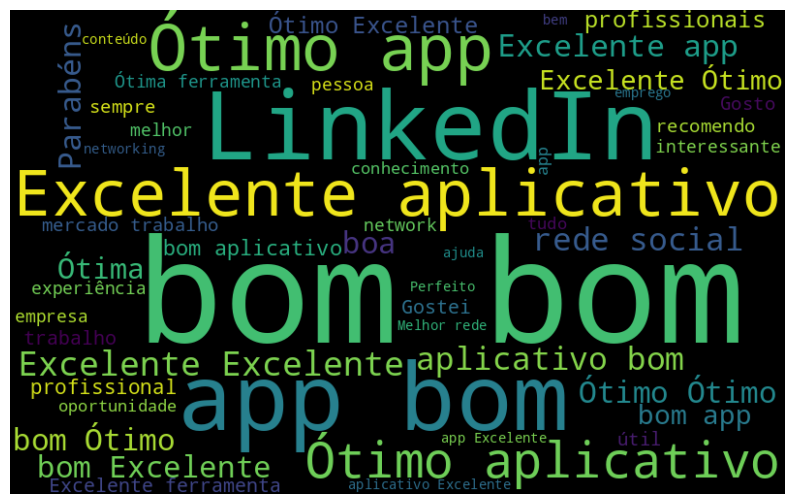

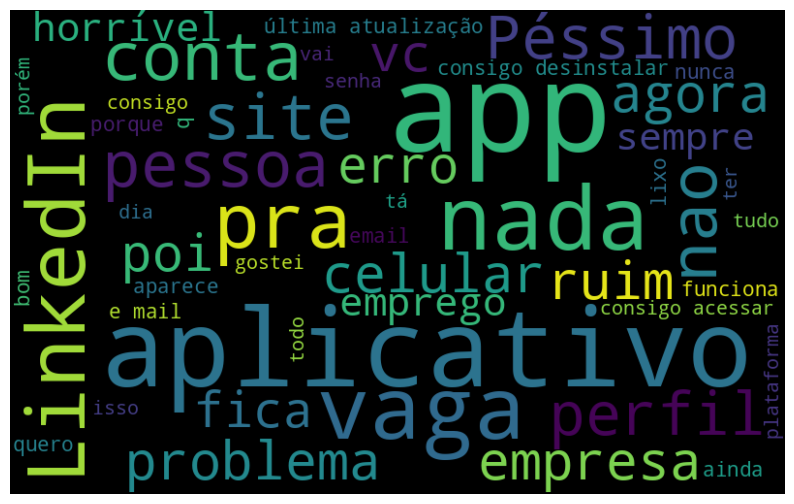

In [7]:
# Baixar as stopwords em português do NLTK
nltk.download('stopwords')

# Definir o conjunto de stopwords em português
portuguese_stopwords = set(stopwords.words('portuguese'))

def nuvem_palavras(texto, coluna_texto, sentimento):
    """
    Gera e exibe uma nuvem de palavras para as resenhas de um determinado sentimento.

    Parâmetros:
    - texto: DataFrame contendo as resenhas e os sentimentos
    - coluna_texto: Nome da coluna que contém o texto das resenhas
    - sentimento: Sentimento a ser filtrado ('POS' para positivo, 'NEG' para negativo)
    """
    # Filtrar as resenhas com base no sentimento especificado
    texto_sentimento = texto.query(f"sentimento == '{sentimento}'")[coluna_texto]

    # Unir todas as resenhas em uma única string
    texto_unido = " ".join(texto_sentimento)

    # Dividir o texto em palavras e remover as stopwords
    palavras = texto_unido.split()
    palavras_filtradas = [palavra for palavra in palavras if palavra.lower() not in portuguese_stopwords]
    texto_filtrado = " ".join(palavras_filtradas)

    # Criar e exibir a nuvem de palavras
    nuvem_palavras = WordCloud(width=800, height=500, max_words=50).generate(texto_filtrado)
    plt.figure(figsize=(10, 7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Gerar a nuvem de palavras para resenhas positivas
nuvem_palavras(dados, 'content', 'POS')

# Gerar a nuvem de palavras para resenhas negativas
nuvem_palavras(dados, 'content', 'NEG')